In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import datetime 
import yfinance as yf 
from scipy.stats import norm 
import requests 
from io import StringIO
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(10,6)

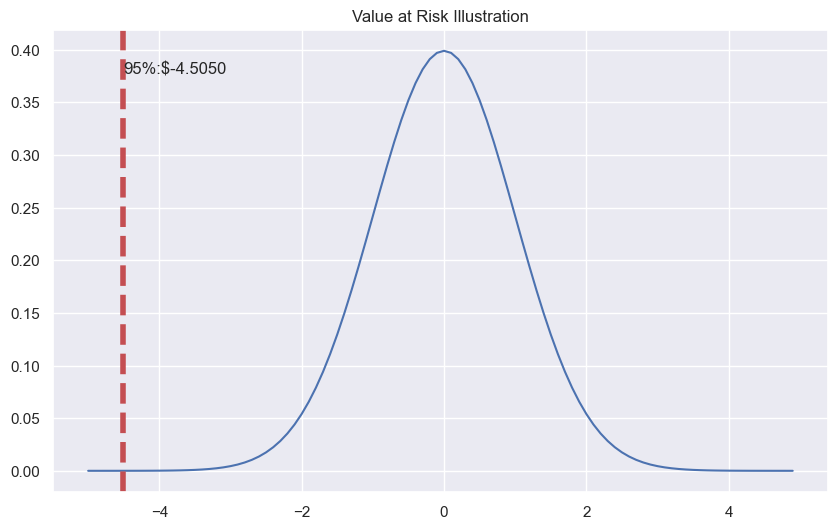

In [4]:
mean=0
std_dev=1
x=np.arange(-5,5,0.1)
y=norm.pdf(x,mean,std_dev)
pdf=plt.plot(x,y)
min_ylim, max_ylim=plt.ylim()
plt.text(np.percentile(x,5), max_ylim*0.9, '95%:${:.4f}'.format(np.percentile(x,5)))
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed',
linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

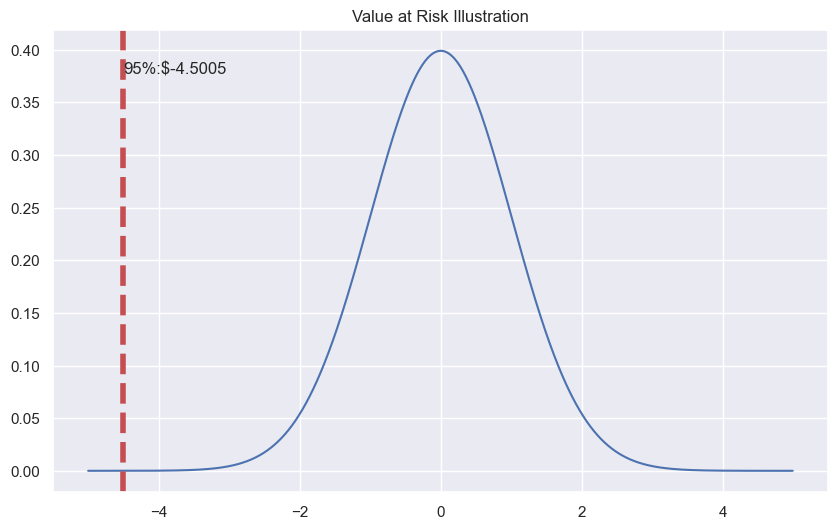

In [5]:
mean = 0 
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev) 
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
.format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
linewidth=4)
plt.title('Value at Risk Illustration') 
plt.show()

In [10]:
def getDailyData(symbol):
    parameters={'function':'Time_SERIES_DAILY_ADJUSTED',
    'symbol':symbol,
    'outputsize':'full',
    'datatype':'csv',
    'apikey':'MD3'}
    response=requests.get('https://www.alphavantage.co/query',
    params=parameters)
    csvText=StringIO(response.text)
    data=pd.read_csv(csvText, index_col='timestamp')
    return data

In [11]:
symbols=['IBM', 'MSFT', 'INTC']
stock3=[]
for symbol in symbols:
    stock3.append(getDailyData(symbol)[::-1]['close']
    ['2020-01-01':'2020-12-31'])
stocks=pd.DataFrame(stock3).T
stocks.columns=symbols


In [12]:
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,135.42,160.62,60.84
2020-01-03,134.34,158.62,60.10
2020-01-06,134.10,159.03,59.93
2020-01-07,134.19,157.58,58.93
2020-01-08,135.31,160.09,58.97


In [13]:
stocks_returns=(np.log(stocks)-np.log(stocks.shift(1))).dropna()
stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
2020-01-09,0.010513,0.012416,0.005580
...,...,...,...
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000
2020-12-29,-0.008205,-0.003607,0.048112


In [38]:
stocks_returns_mean=stocks_returns.mean()
weights=np.random.random(len(stocks_returns.columns))
weights/=np.sum(weights)
cov_var=stocks_returns.cov()
port_std=np.sqrt(weights.T.dot(cov_var).dot(weights))

In [39]:
initial_investment=1e6
conf_level=0.95

In [45]:
stocks.columns

Index(['IBM', 'MSFT', 'INTC'], dtype='object')

In [57]:
def VaR_parametric(initial_investment, conf_level):
    alpha=norm.ppf(1-conf_level, stocks_returns_mean, port_std)
    VaR_param=(initial_investment-initial_investment*(1+alpha))
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        Var_param=(initial_investment-initial_investment*(1+alpha))[j]
        print('Parametric VaR result for {} is {}'.format(i, VaR_param[j]))
    
    print('--'*25)
    return VaR_param



In [58]:
VaR_param=VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is 42823.81311563135
Parametric VaR result for MSFT is 41242.153800188215
Parametric VaR result for INTC is 43326.90426521783
--------------------------------------------------


array([42823.81311563, 41242.15380019, 43326.90426522])

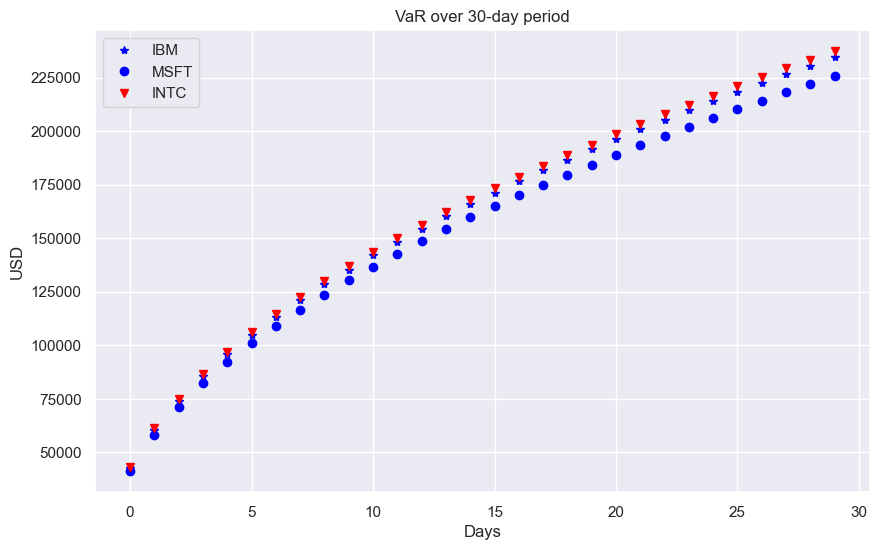

In [61]:
var_horizon=[]
time_horizon=30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon+1):
        var_horizon.append(VaR_param[j]*np.sqrt(i))
plt.plot(var_horizon[:time_horizon], 'o',
c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon+30], 'o',
c='blue', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon+30:time_horizon+60],'o',
c='red',marker='v', label='INTC')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('VaR over 30-day period')
plt.legend()
plt.show()

In [73]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95=[]
    
    for i, j in zip(stocks_returns.columns,\
        range(len(stocks_returns.columns))):

        Hist_percentile95.append(np.percentile(stocks_returns.loc[:,i],
        5))
        print("Based on historical values 95% of {}'s return is {:.4f}"\
            .format(i, Hist_percentile95[j]))
        VaR_historical=(initial_investment-initial_investment*(1+Hist_percentile95[j]))
        print('Histrical VaR result for {} is {:.2f}'.format(i,VaR_historical))
        print('--'*35)

In [74]:
VaR_historical(initial_investment, conf_level)

Based on historical values 95% of IBM's return is -0.0371
Histrical VaR result for IBM is 37081.53
----------------------------------------------------------------------
Based on historical values 95% of MSFT's return is -0.0426
Histrical VaR result for MSFT is 42583.68
----------------------------------------------------------------------
Based on historical values 95% of INTC's return is -0.0425
Histrical VaR result for INTC is 42485.39
----------------------------------------------------------------------


In [75]:
x= np.random.uniform(-1,1,100)
y=np.random.uniform(-1,1,100)

sample=100
def pi_calc(x,y):
    point_inside_circle=0
    for i in range(sample):
        if np.sqrt(x[i]**2+y[i]**2)<=1:
            point_inside_circle+=1
    print('pi value is {}'.format(4*point_inside_circle/sample))

In [78]:
pi_calc(x,y)


pi value is 3.16


In [81]:
x=np.random.uniform(-1,1,1000000)
y=np.random.uniform(-1,1,1000000)
sample=1000000

In [82]:
pi_calc(x,y)


pi value is 3.141704


In [83]:
sim_data=pd.DataFrame([])
num_reps=1000
n=100
for i in range(len(stocks.columns)):
    mean=np.random.randn(n).mean()
    std=np.random.randn(n).std()
    temp=pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data=pd.concat([sim_data,temp],axis=1)
sim_data.columns=['Simulation 1', 'Simulation 2', 'Simulation 3']


In [84]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.156539,-0.688011,-0.008642
1,0.762571,-1.524895,-2.410996
2,0.940956,-2.321178,0.551591
3,-0.075808,-0.923141,-0.762717
4,0.972370,-1.400443,-0.952705
...,...,...,...
995,0.046680,0.427259,-0.707502
996,-1.140600,-2.130504,-0.071362
997,0.963602,0.597451,-1.195729
998,0.995553,-0.189769,0.377299


In [85]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95=[]
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:,i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}".format(i, MC_percentile95[j]))
        VaR_MC=(initial_investment-initial_investment*(1+MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f}".format(i, VaR_MC))
        print('--'*35)

In [86]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.3218
Simulation VaR result for Simulation 1 is 1321816.20
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.8024
Simulation VaR result for Simulation 2 is 1802437.53
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.4074
Simulation VaR result for Simulation 3 is 1407445.63
----------------------------------------------------------------------


In [87]:
def mp_pdf(sigma2,q, obs):
    lambda_plus=sigma2*(1+q**0.5)**2
    lambda_minus=sigma2*(1-q**0.5)**2
    l=np.linspace(lambda_minus, lambda_plus,obs)
    pdf_mp=1/(2*np.pi*sigma2*q*l)\
        *np.sqrt((lambda_plus-l)
        *(l-lambda_minus))
    pdf_mp=pd.Series(pdf_mp, index=l)
    return pdf_mp

In [105]:
from sklearn.neighbors import KernelDensity

def kde_fit(bandwidth,obs,x=None):
    kde=KernelDensity(bandwidth=0.01, kernel='gaussian')
    if len(obs.shape)==1:
        kde_fit=kde.fit(np.array(obs).reshape(-1,1))
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logprob=kde_fit.score_samples(x)
    pdf_kde=pd.Series(np.exp(logprob), index=x.flatten())
    return pdf_kde

In [101]:
corr_mat=np.random.normal(size=(10000, 1000))
corr_coef=np.corrcoef(corr_mat, rowvar=0)
sigma2=1
obs=corr_mat.shape[0]
q=corr_mat.shape[0]/corr_mat.shape[1]

def plotting(corr_coef,q):
    ev, _=np.linalg.eigh(corr_coef)
    idx=ev.argsort()[::-1]
    eigen_val=np.diagflat(ev[idx])
    pdf_mp=mp_pdf(1., q=corr_mat.shape[1]/corr_mat.shape[0],
    obs=1000)
    kde_pdf=kde_fit(0.01, np.diag(eigen_val))
    ax=pdf_mp.plot(title='Marchenko-pastur Theorem', label='M-P', style='r--')
    kde_pdf.plot(label='Empirical Density', style='o-', alpha=0.3 )
    ax.set(xlabel='Eigenvalue', ylabel='Frequency')
    ax.legend(loc='upper right')
    plt.show()
    return plt

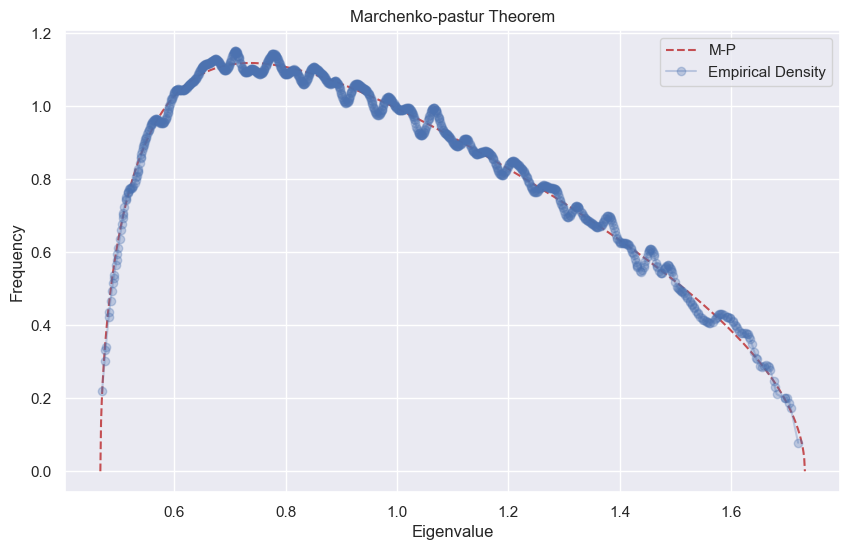

<module 'matplotlib.pyplot' from 'c:\\Users\\yim\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [106]:
plotting(corr_coef,q)

In [108]:

asset1 = [-0.5, 0, 0.1, 0.4]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1)) 
asset2 = [0, -0.5, 0.01, 0.4]
VaR2 = np.percentile(asset2, 90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2)) 
VaR_all = np.percentile(asset1 + asset2, 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))


VaR for the Asset 1 is 0.3100
VaR for the Asset 2 is 0.2830
VaR for the portfolio is 0.4000


In [109]:
asset1 = [-0.5, 0, 0.05, 0.03]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1)) 
asset2 = [0, -0.5, 0.02, 0.8]
VaR2 = np.percentile(asset2,90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2)) 
VaR_all = np.percentile(asset1 + asset2 , 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))


VaR for the Asset 1 is 0.0440
VaR for the Asset 2 is 0.5660
VaR for the portfolio is 0.2750


In [110]:
def ES_parametric(initial_investment , conf_level):
    alpha = - norm.ppf(1 - conf_level,stocks_returns_mean,port_std) 
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
            * initial_investment \
            * norm.expect(lambda x: x,
                lb = norm.ppf(conf_level,
                stocks_returns_mean[j], 
                port_std),
            loc = stocks_returns_mean[j], 
            scale = port_std)
        print(f"Parametric ES result for {i} is {ES_param}")

In [111]:
ES_parametric(initial_investment, conf_level)

Parametric ES result for IBM is 53049.36817147941
Parametric ES result for MSFT is 54631.02748692253
Parametric ES result for INTC is 52546.27702189303


In [113]:
def ES_historical(initial_investment, conf_level):
    for i, j in zip(stocks_returns.columns,
        range(len(stocks_returns.columns))):
        ES_hist_percentile95 = np.percentile(stocks_returns.loc[:, i],5)
        ES_historical = stocks_returns[str(i)][stocks_returns[str(i)] <=
        ES_hist_percentile95].mean()
        print("Historical ES result for {} is {:.4f} ".format(i, initial_investment * ES_historical))

In [114]:
ES_historical(initial_investment, conf_level)

Historical ES result for IBM is -64802.3898 
Historical ES result for MSFT is -65765.0848 
Historical ES result for INTC is -88462.7404 
